# Full A/B Test Simulation

## Overview

This simulation models a controlled A/B test to evaluate the effect of a treatment intervention on user outcomes.  
The simulated outcome represents a **continuous performance metric** (e.g., revenue, engagement time, or conversions), **scaled by baseline activity**.

A total of **2,000 users** were randomly assigned (**stratified by baseline activity**) into treatment and control groups in equal proportion. The treatment group received a **10% multiplicative boost** relative to baseline performance, with added Gaussian noise (*σ* = 0.5).

**Goal**<br>
To test the hypothesis that treatment significantly improves outcomes, both in raw comparison and when adjusting for baseline activity.

#### 1. Import Libraries

In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
import importlib.metadata

#### 2. Set Parameters

In [2]:
np.random.seed(42)
n_users = 2000
treatment_frac = 0.5
treatment_effect = 0.10  # 10% increase
sigma_noise = 0.5
n_strata = 4
winsor_limits = (0.01, 0.01)

The simulation parameters define sample size, randomization ratio, treatment strength, and noise level. **Winsorization limits** are also defined to reduce the impact of extreme outliers in the outcome variable.

## Baseline

#### 3. Generate Baseline Data

In [3]:
baseline = np.random.gamma(shape=2, scale=50, size=n_users)
data = pd.DataFrame({
    "user_id": np.arange(n_users),
    "baseline": baseline
})

##### **Stratified Randomized Grouping**

In [4]:
data["strata"] = pd.qcut(data["baseline"], q=n_strata, labels=False)
data["group"] = np.nan

for s in data["strata"].unique():
    idx = data[data["strata"] == s].index
    n_treat = int(np.round(len(idx) * treatment_frac))
    shuffled_idx = np.random.permutation(idx)
    data.loc[shuffled_idx[:n_treat], "group"] = "treatment"
    data.loc[shuffled_idx[n_treat:], "group"] = "control"

#### 4. Baseline Balance Check

In [5]:
summary_baseline = data.groupby("group")["baseline"].agg(
    n="count",
    mean="mean",
    std="std",
    min="min",
    median="median",
    max="max"
).reset_index()
print("\nBaseline summaries by group:")
summary_baseline


Baseline summaries by group:


,group,n,mean,std,min,median,max
0,control,1000,101.780937,70.807729,1.617404,86.439376,680.511634
1,treatment,1000,102.823113,71.476561,1.293024,86.398692,392.802157


##### **Baseline Distribution Visualization**

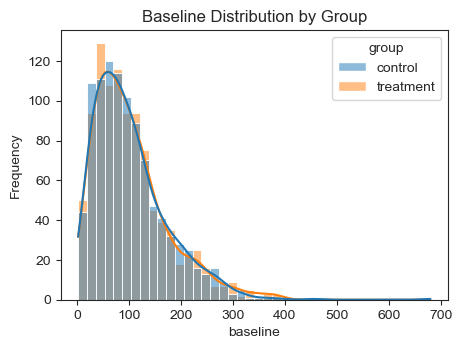

In [6]:
def plot_distribution(metric, title, bins):
    plt.figure(figsize=(5, 3.5))
    sns.histplot(data=data, x=metric, hue="group", bins=bins, kde=True)
    plt.title(title)
    plt.xlabel(metric)
    plt.ylabel("Frequency")
    plt.show()

sns.set_style("ticks")
plot_distribution("baseline", "Baseline Distribution by Group", 40)

The stratified randomization successfully ensured **similar baseline means** between control and treatment, confirming balance before intervention.

## Treatment Effects
#### 5. Simulate Treatment Outcomes

In [7]:
data["outcome"] = data["baseline"] * (
    1 + treatment_effect * (data["group"] == "treatment")
) + np.random.normal(0, sigma_noise, size=n_users)

# Winsorize to control outliers
def winsorize(series, lims=(0, 0)):
    return stats.mstats.winsorize(series, limits=lims)
data["outcome_win"] = winsorize(data["outcome"], lims=winsor_limits)

Subsequent analyses use `outcome_win` (winsorized outcome) to mitigate the influence of extreme outliers.
<br><br>
##### **Outcome Summaries**

In [8]:
summary_outcome = data.groupby("group").agg(
    n=("outcome_win", "count"),
    mean=("outcome_win", "mean"),
    std=("outcome_win", "std"),
    min=("outcome_win", "min"),
    median=("outcome_win", "median"),
    max=("outcome_win", "max")
).reset_index()
print("\nOutcome summaries:")
summary_outcome


Outcome summaries:


,group,n,mean,std,min,median,max
0,control,1000,101.294830,68.037673,8.860655,86.463161,344.850824
1,treatment,1000,112.466526,76.223421,8.860655,95.016198,344.850824


##### **Outcome Distribution Visualization**

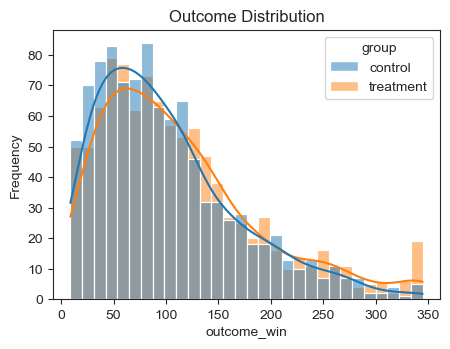

In [9]:
plot_distribution("outcome_win", "Outcome Distribution", 30)

The treatment group showed a rightward shift in outcome distribution, reflecting the intended 10% improvement with controlled noise.

## Statistical Tests and Results
#### 6. Unadjusted Welch’s t-Test
The Welch’s t-test compares group means without assuming equal variance. A significant *p*-value indicates treatment improved outcomes.

In [10]:
a = data.loc[data["group"] == "control", "outcome_win"]
b = data.loc[data["group"] == "treatment", "outcome_win"]

# Welch’s t-test
t_stat, p_ttest = stats.ttest_ind(b, a, equal_var=False)

mean_control = a.mean()
mean_treat = b.mean()
std_control = a.std(ddof=1)
std_treat = b.std(ddof=1)

n_control = len(a)
n_treat = len(b)

# Difference and standard error
diff = mean_treat - mean_control
se_diff = np.sqrt((std_control**2 / n_control) + (std_treat**2 / n_treat))

# Welch–Satterthwaite degrees of freedom
df = ((std_control**2 / n_control + std_treat**2 / n_treat) ** 2) / (
    ((std_control**2 / n_control) ** 2) / (n_control - 1)
    + ((std_treat**2 / n_treat) ** 2) / (n_treat - 1)
)

# Critical t for 95% CI
t_crit = stats.t.ppf(0.975, df)

# Confidence interval
ci_lower = diff - t_crit * se_diff
ci_upper = diff + t_crit * se_diff

# Cohen's d (pooled SD)
cohen_d = diff / np.sqrt((std_control**2 + std_treat**2) / 2)

def significance(p_value):
    if p_value < 0.001:
        return "p < 0.001"
    elif p_value < 0.05:
        return f"p = {p_value:.4f}"
    else:
        return f"p = {p_value:.4f} (n.s.)"

print(
    f"Treatment effect: {diff:.2f} ± {se_diff:.2f} (95% CI [{ci_lower:.2f}, {ci_upper:.2f}]), "
    f"t({df:.1f}) = {t_stat:.2f}, {significance(p_ttest)}, d = {cohen_d:.3f}"
)

Treatment effect: 11.17 ± 3.23 (95% CI [4.84, 17.51]), t(1972.8) = 3.46, p < 0.001, d = 0.155


The treatment group (*M* = 112.47, *SD* = 76.22) had a significantly higher outcome than the control group (*M* = 101.29, *SD* = 68.04); *t* (Welch) = 3.46, *p* < 0.001, with a 95% confidence interval for estimated mean increase of [4.84, 17.51] and an effect size (d = 0.155). This represents a small effect according to Cohen’s conventions.
<br><br>
#### 7. Baseline-Adjusted ANCOVA
An Analysis of Covariance (ANCOVA) was fitted to account for individual baseline variation, isolating the treatment’s marginal effect.

In [11]:
def run_ancova(outcome_var):
    model = smf.ols(
        f"{outcome_var} ~ C(group, Treatment(reference='control')) + baseline",
        data=data
    ).fit(cov_type="HC3")

    treatment_param = [p for p in model.params.index if "T.treatment" in p][0]
    
    coef = model.params[treatment_param]
    se = model.bse[treatment_param]
    t_val = model.tvalues[treatment_param]
    p_val = model.pvalues[treatment_param]
    r2 = model.rsquared_adj
    return coef, se, t_val, p_val, r2
    
coef_raw, se_raw, t_raw, p_raw, r2_raw = run_ancova("outcome_win")

print(
    f"Coef: {coef_raw:.2f} (robust SE = {se_raw:.2f}, t = {t_raw:.2f}, {significance(p_raw)}), "
    f"adjusted R²: {r2_raw:.3f}"
)

Coef: 10.12 (robust SE = 0.45, t = 22.31, p < 0.001), adjusted R²: 0.983


After adjusting for baseline, the treatment group again showed significantly higher outcomes than the control group. Treatment **increased outcome by 10.12 units** (robust *SE* = 0.454, *t* = 22.31, *p* < 0.001). Baseline was a strong positive predictor, and the model explained a substantial proportion of variance (**adjusted *R²*: 0.983**).

This corresponds to an approximate 10% increase relative to baseline mean, consistent with the designed treatment effect. In contrast, the unadjusted Welch’s t-test produced a slightly inflated mean difference (**+11.17 units**) due to residual baseline variance. This shows that adjusting for baseline variation improves precision and recovers the true underlying lift more accurately than raw group comparison.

## Discussion
The results demonstrate that the simulated treatment achieved a measurable and statistically significant uplift in outcomes. This uplift translates to potential gains in key performance metrics such as revenue or engagement, depending on the specific intervention context.

The ANCOVA results further validate that this uplift is not due to baseline imbalance. Baseline was strongly correlated with outcome, but the treatment effect remained significant even after controlling for it.

The adjusted model provided a more accurate estimate of the true 10% treatment lift by controlling for baseline heterogeneity, thereby reducing residual variance and enhancing statistical power.

##### **Limitations**
- This is a synthetic dataset. Real-world data may differ in skew, attrition, or interaction effects.
- Assumes a constant treatment effect across strata which might not be applicable in real-world data.
- Normality assumption not explicitly tested (though robust SEs mitigate risk).

##### **Next Steps**
- Explore heterogeneous treatment effects by baseline quartile or demography proxy.
- Test pipeline on real production data or observational analogs.

## Conclusion

This end-to-end simulation provides a statistically rigorous and reproducible demonstration of A/B testing methodology. With stratified randomization, winsorized outcomes, and baseline adjustment, it achieves reliable inference, aligning with modern experimentation standards in data science.

#### 8. Versions
Package versions are reported for reproducibility. All analyses were performed in **Python 3.11** with the following packages:
`numpy`, `pandas`, `scipy`, `statsmodels`, `seaborn`, `matplotlib`, and `importlib`.

In [12]:
libraries = [
    "numpy", "pandas", "scipy", "statsmodels",
    "seaborn", "matplotlib", "importlib.metadata"
]
print("\nEnvironment Versions")

print(f"\nPython: {sys.version.split()[0]}")
for lib in libraries:
    try:
        print(f"{lib}: {importlib.metadata.version(lib)}")
    except importlib.metadata.PackageNotFoundError:
        print(f"{lib}: Not Found")


Environment Versions

Python: 3.11.0
numpy: 1.25.2+2.g530bd4c06
pandas: 2.0.3
scipy: 1.11.2
statsmodels: 0.14.0
seaborn: 0.13.1
matplotlib: 3.9.0.dev16+g5446a454e4
importlib.metadata: 8.7.0
